# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver el problema de encontrar un Máximo Óptimo  definido al azar en un plano (tener en cuenta que debería esquivar  máximos locales aleatorios)
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
!pip install deap

1) Importar librerías:

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import operator

from deap import base
from deap import creator
from deap import tools
from deap import benchmarks

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [3]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3

# Espacio mínimo y máximp del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 350

# Cantidad de Particulas
CANT_PARTICULAS = 5

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Inicializar objetos de DEAP para utilizar e indicar parámetros de PSO:

In [4]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)

def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

def updateParticle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part[:] = list(map(operator.add, part, part.speed))

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=2, pmin=MIN_ESPACIO_BUSQ, pmax=MAX_ESPACIO_BUSQ, smin=MIN_ESPACIO_BUSQ//10, smax=MAX_ESPACIO_BUSQ//10)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)

print("\nObjetos de PSO definidos")


Objetos de PSO definidos


In [5]:
### FUNCIÓN HEURÍSTICA

# Define Posiciones Random para Máximos Locales y Óptimos
# con Heurística también al Azar (entre -10 y 100)
POS_RANDOM_EVALUAR = []
VAL_RANDOM_EVALUAR = []
POS_RANDOM_EVALUAR_OPTIMO = 0
auxMejorVal = -99
print("** Posiciones Generadas al Azar: **")
for i in range(CANT_MAXIMOS_LOCALES+1):

    auxPos = ( round(random.uniform(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ),3),  round(random.uniform(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ),3) ) 
    auxVal = int(random.uniform(-10, 100))

    POS_RANDOM_EVALUAR.append( auxPos )
    VAL_RANDOM_EVALUAR.append( auxVal )
    
    print(" -->", auxPos, "{ ", auxVal, "} ")

    if VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO] < auxVal:
        POS_RANDOM_EVALUAR_OPTIMO = i

print("** Posición Máximo Óptimo a Buscar: ", POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO], " { ",  VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]," } **")

# definimos la función a evaluar
def funcHeuristica(particula):

    devuelve = -10
    disPosMenor = MAX_ESPACIO_BUSQ
    for posi, vali in zip(POS_RANDOM_EVALUAR, VAL_RANDOM_EVALUAR):

          # calcula la distancia al punto de la Particula
          sqerrors = ((x - y)**2 for x, y in zip(particula, posi))
          distPos =  math.fsum(sqerrors)**0.5 / 10
          
          # Si es la menor distancia calcula la Heurística
          if disPosMenor > distPos:
              disPosMenor = distPos 
              devuelve = ( vali - distPos) 

    return devuelve,


# registra la función que se va a evaluar
toolbox.register("evaluate", funcHeuristica)

print("\nFunción Heurística definida")

** Posiciones Generadas al Azar: **
 --> (948.624, -596.893) {  0 } 
 --> (-956.814, 910.62) {  47 } 
 --> (860.647, 856.824) {  63 } 
 --> (-323.592, 340.57) {  47 } 
** Posición Máximo Óptimo a Buscar:  (860.647, 856.824)  {  63  } **

Función Heurística definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
## EJECUCIÓN DE LA CORRIDA

# Define la población inicial
partPobla = toolbox.population(n=CANT_PARTICULAS)

# vectores auxiliares 
ciclo = 1    
mejorPart = None
ciclosParticulas = []
ciclosMaxAptitud = []

while (ciclo < CANT_CICLOS):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)        

    # Evalúa las partículas
    for part in partPobla:
       
        # Genera una copia de las partículas para el gráfico
        clonePart = list(map(toolbox.clone, part))
        ciclosParticulas.append( clonePart )

        part.fitness.values = toolbox.evaluate(part)
        if not part.best or part.best.fitness < part.fitness:
            part.best = creator.Particle(part)
            part.best.fitness.values = part.fitness.values

        if not mejorPart or mejorPart.fitness < part.fitness:
            mejorPart = creator.Particle(part)
            mejorPart.fitness.values = part.fitness.values


    ciclosMaxAptitud.append( mejorPart.fitness.values[0] )

    if MUESTRA_DETALLE:
        print(" Mejor Partícula:", mejorPart, " ( ", mejorPart.fitness.values[0], " ) ")

    # Actualiza las partículas
    for part in partPobla:
        toolbox.update(part, mejorPart)
    

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO], " { ",  VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]," } **")
print("== Mejor Partícula de la Corrida:", mejorPart, " { ", mejorPart.fitness.values[0], " } ==")


-- Ciclo  1 --
 Mejor Partícula: [346.03899739325584, 561.4354087185868]  (  3.664023037779124  ) 

-- Ciclo  2 --
 Mejor Partícula: [349.20578407540916, 558.4475384421083]  (  3.7884614151741616  ) 

-- Ciclo  3 --
 Mejor Partícula: [352.37257075756247, 555.4596681656299]  (  3.909953805763358  ) 

-- Ciclo  4 --
 Mejor Partícula: [355.5393574397158, 552.4717978891514]  (  4.028482001687394  ) 

-- Ciclo  5 --
 Mejor Partícula: [358.7061441218691, 549.4839276126729]  (  4.144028094447549  ) 

-- Ciclo  6 --
 Mejor Partícula: [361.8729308040224, 546.4960573361944]  (  4.256574486989265  ) 

-- Ciclo  7 --
 Mejor Partícula: [365.03971748617573, 543.508187059716]  (  4.366103905746741  ) 

-- Ciclo  8 --
 Mejor Partícula: [368.20650416832905, 540.5203167832375]  (  4.472599412631347  ) 

-- Ciclo  9 --
 Mejor Partícula: [371.37329085048236, 537.532446506759]  (  4.576044416947084  ) 

-- Ciclo  10 --
 Mejor Partícula: [374.5400775326357, 534.5445762302805]  (  4.676422687215542  ) 

-- 

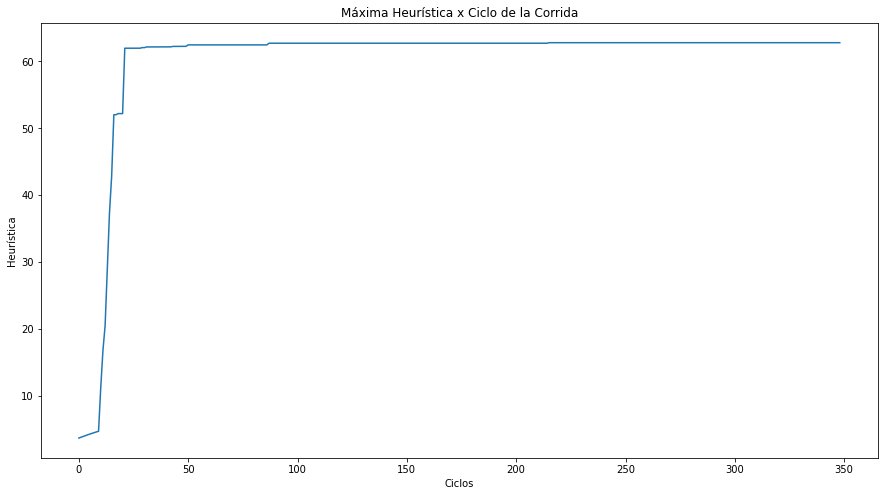

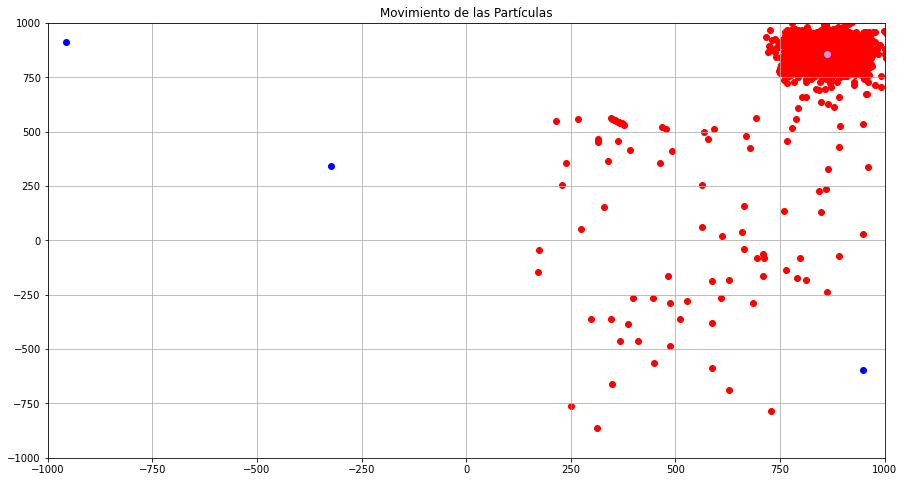

In [7]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.show()


## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS PARTICULAS
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones de las particulas de cada ciclo
for part in ciclosParticulas:
  plt.scatter(part[0], part[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(POS_RANDOM_EVALUAR, VAL_RANDOM_EVALUAR):
  if posi == POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]:
      plt.scatter(posi[0], posi[1], color='green')
  elif vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')

## --en Violeta: Mejor posición de las partículas
plt.scatter(mejorPart[0], mejorPart[1], color='violet')

plt.title('Movimiento de las Partículas')
plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
